# Function approximation

## 切比雪夫多项式零点插值逼近

In [1]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name:chebyshev_zero_points_interp.py
@IDE:PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import sympy
from interpolation_02.lagrange_interpolation import LagrangeInterpolation  # 拉格朗日插值
from util_font import *


class ChebyshevZeroPointsInterpolation:
    """
    切比雪夫多项式零点插值算法
    """
    terms_zeros = None  # 切比雪夫多项式零点
    approximation_poly = None  # 逼近的多项式
    poly_coefficient, polynomial_orders = None, None  # 逼近多项式的系数，各项阶次
    max_abs_error, mae = None, None  # 逼近多项式的最大绝对值误差，绝对误差均值mae

    def __init__(self, approximate_fx, orders=6, x_span=np.array([-1, 1])):
        """
        必要参数的初始化
        """
        self.approximate_fx = approximate_fx
        self.orders = int(orders)  # 插值最高阶次
        self.a, self.b = x_span[0], x_span[1]

    def fit_approximation(self):
        """
        切比雪夫多项式零点插值核心算法：先求零点并变换空间，再进行拉格朗日插值，生成p(x)
        :return:
        """
        k = np.arange(0, self.orders + 1)  # 切比雪夫零点索引下标
        zero = np.cos((2 * k + 1) / 2 / (self.orders + 1) * np.pi)
        self.terms_zeros = (self.b - self.a) / 2 * zero + (self.b + self.a) / 2  # 存储零点，区间变换
        fun_values = self.approximate_fx(self.terms_zeros)  # 零点的函数值
        lag = LagrangeInterpolation(self.terms_zeros, fun_values)  # 拉格朗日插值
        lag.fit_interp()  # 生成拉格朗日插值多项式，符号多项式
        self.approximation_poly = lag.polynomial  # 插值后的逼近多项式
        self.poly_coefficient = lag.poly_coefficient  # 多项式系数
        self.polynomial_orders = lag.coefficient_order  # 多项式的阶次
        self.error_analysis()  # 误差分析

    def predict_x0(self, x0):
        """
        求解逼近多项式p(x)在给定点x0的值
        :return:
        """
        t = self.approximation_poly.free_symbols.pop()  # 提取自由变量
        appr_poly = sympy.lambdify(t, self.approximation_poly)  # 转换为lambda函数
        return np.array(appr_poly(x0))

    def error_analysis(self):
        """
        误差分析：10轮模拟，每轮100个服从U(a,b)的随机点，选取最大绝对误差和计算绝对误差均值
        :return:
        """
        mae = np.zeros(10)  # 存储10次随机值，真值与逼近多项式的均方根误差
        max_error = np.zeros(10)  # 存储10次随机模拟，每次最大的绝对值误差
        for i in range(10):
            xi = self.a + np.random.rand(1000) * (self.b - self.a)
            xi = np.array(sorted(xi))  # list-->ndarray，升序排列
            y_true = self.approximate_fx(xi)  # 真值
            yi_hat = self.predict_x0(xi)  # 预测值
            mae[i] = np.mean(np.abs(yi_hat - y_true))  # 100个随机点的绝对误差均值
            max_error[i] = max(np.abs(yi_hat - y_true))  # 100个随机点选最大的绝对值误差
            idx = np.argmax(np.abs(yi_hat - y_true))
            # print(i, ":", xi[idx], np.abs(yi_hat - y_true)[idx])
        self.max_abs_error = max(max_error)  # 10次模拟选最大的
        self.mae = np.mean(mae)  # 10次模拟均值

    def plt_approximation(self, is_show=True, is_fh_marker=False):
        """
        可视化逼近多项式。针对被逼近函数，如果is_fh_marker为True，则随机化50个点，并标记
        :param is_show: 用于绘制子图，如果绘制子图，则值为False
        :param is_fh_marker: 真实函数是曲线类型还是marker类型
        """
        if is_show:
            plt.figure(figsize=(7, 5))
        xi = np.linspace(self.a, self.b, 200)
        yi_hat = self.predict_x0(xi)  # 求解模拟点
        plt.plot(xi, yi_hat, "r-", lw=2, label="$p(x) \ (k=%d)$" % self.orders)
        if is_fh_marker:
            xi = self.a + np.random.rand(50) * (self.b - self.a)
            xi = np.array(sorted(xi))  # list-->ndarray，升序排列
            y_true = self.approximate_fx(xi)
            plt.plot(xi, y_true, "k*", label="$f(x_k), \ x_k \sim U(a, b)$")
        else:
            y_true = self.approximate_fx(xi)
            plt.plot(xi, y_true, "k--", lw=2, label="$f(x)$")
        plt.xlabel(r"$x$", fontdict={"fontsize": 18})
        plt.ylabel(r"$f(x) \ / \ p(x)$", fontdict={"fontsize": 18})
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        # mse_10的含义为10次随机绝对误差均值
        plt.title("切比雪夫零点插值逼近$(MAE_{10}=%.2e)$" % self.mae, fontdict={"fontsize": 18})
        plt.legend(frameon=False, fontsize=18, loc="best")  # loc="upper left"
        plt.grid(ls=":")
        if is_show:
            plt.show()


最大逼近多项式绝对值误差： 2.9454010144203124e-05
零点值： [0.97552826 0.79389263 0.5        0.20610737 0.02447174]
拉格朗日插值逼近多项式系数以及阶次：
[0.0694155133774643, 0.140275036852586, 0.509779835305423, 0.998757050931840, 1.00002493721519]
[(4,), (3,), (2,), (1,), (0,)]
4 1.7185776215484692e-05
5 7.174962883219616e-07
6 2.5623705791821828e-08
7 7.942037189012652e-10
8 2.4320423142043524e-11
9 7.2091002722984865e-12
10 1.3586967817502682e-11
11 9.93164213092257e-10
12 1.878697041335364e-09
13 2.2108447365365437e-08
14 9.603179013544237e-08
15 6.849013549238947e-07
16 7.005882084768333e-06


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

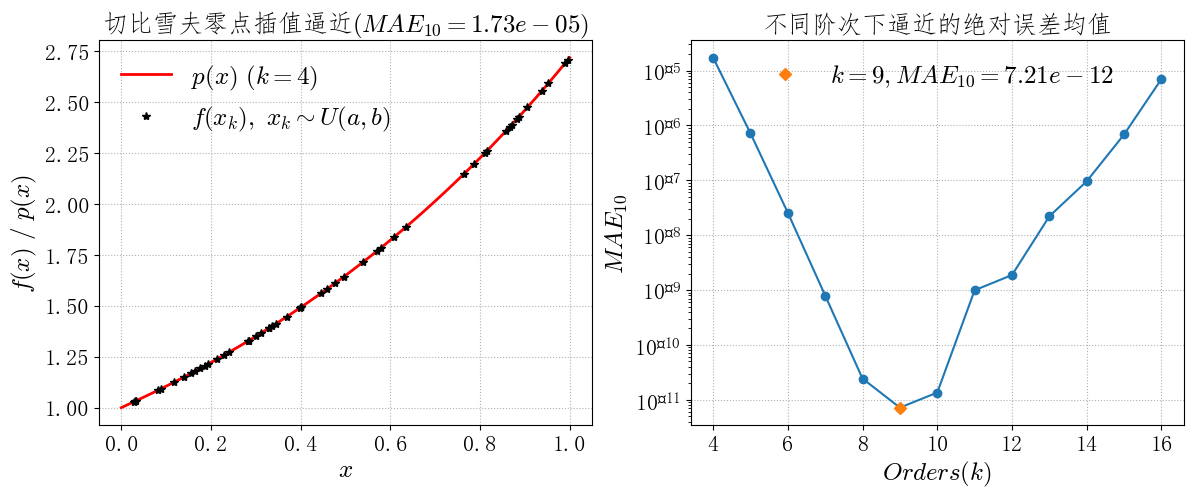

In [2]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name:test_chebyshev_zero_interp.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""

import numpy as np
import matplotlib.pyplot as plt
from function_approximation_03.chebyshev_zero_points_interp import ChebyshevZeroPointsInterpolation

# import matplotlib as mpl
# from matplotlib import font_manager

# # 指定中文字体路径（确保路径正确）
# font_path = "/usr/share/fonts/winfonts/simfang.ttf"
# zh_font = font_manager.FontProperties(fname=font_path)

# # 设置字体和数学字体
# mpl.rcParams["font.family"] = zh_font.get_name()
# mpl.rcParams["axes.unicode_minus"] = False
# plt.rcParams["mathtext.fontset"] = "cm"

# 例1测试代码
fun = lambda x: np.exp(x)  # 被逼近函数
plt.figure(figsize=(14, 5))
czpi = ChebyshevZeroPointsInterpolation(fun, orders=4, x_span=[0, 1])
czpi.fit_approximation()
print("最大逼近多项式绝对值误差：", czpi.max_abs_error)
print("零点值：", czpi.terms_zeros)
print("拉格朗日插值逼近多项式系数以及阶次：")
print(czpi.poly_coefficient)
print(czpi.polynomial_orders)
plt.subplot(121)
czpi.plt_approximation(is_show=False, is_fh_marker=True)
orders = np.linspace(4, 16, 13, dtype=int)
mae = []
for k in orders:
    czpi = ChebyshevZeroPointsInterpolation(fun, orders=k, x_span=[0, 1])
    czpi.fit_approximation()
    mae.append(czpi.mae)
    print(k, czpi.mae)
plt.subplot(122)
plt.plot(orders, mae, "o-")
idx = np.argmin(mae)
plt.semilogy(orders[idx], mae[idx], "D", label="$k=%d, MAE_{10}=%.2e$" % (orders[idx], mae[idx]))
plt.legend(frameon=False, fontsize=18)
plt.xlabel("$Orders(k)$", fontsize=18)
plt.ylabel("$MAE_{10}$", fontsize=18)
plt.tick_params(labelsize=16)
plt.grid(ls=":")
plt.title("不同阶次下逼近的绝对误差均值", fontsize=18)
plt.show()

fun2 = lambda x: 1 / (1 + x ** 2)  # 龙格函数
fun3 = lambda x: np.tan(np.cos((np.sqrt(3) + np.sin(2 * x)) / (3 + 4 * x ** 2)))  # 被逼近函数

# 例2测试代码
# fun4 = lambda x: np.sin(2 * x) ** 2 * np.exp(-0.5 * x)
# plt.figure(figsize=(14, 5))
# czpi = ChebyshevZeroPointsInterpolation(fun4, orders=10, x_span=[-3, 3])
# czpi.fit_approximation()
# print("最大逼近多项式绝对值误差：", czpi.max_abs_error)
# print("零点值：", czpi.terms_zeros)
# print("拉格朗日插值逼近多项式系数以及阶次：")
# print(czpi.poly_coefficient)
# print(czpi.polynomial_orders)
# plt.subplot(121)
# czpi.plt_approximation(is_show=False)
#
# czpi = ChebyshevZeroPointsInterpolation(fun4, orders=20, x_span=[-3, 3])
# czpi.fit_approximation()
# print("最大逼近多项式绝对值误差：", czpi.max_abs_error)
# print("零点值：", czpi.terms_zeros)
# print("拉格朗日插值逼近多项式系数以及阶次：")
# print(czpi.poly_coefficient)
# print(czpi.polynomial_orders)
# plt.subplot(122)
# czpi.plt_approximation(is_show=False, is_fh_marker=True)
# plt.show()




## 切比雪夫级数逼近

In [3]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:orthogonal_polynomial_ls_fitting.py
@IDE:PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import sympy
from util_font import *


class OrthogonalPolynomialLSFitting:
    """
    正交多项式最小二乘拟合：p(x) = a0*P0(x) + a1*P1(x) + ... + an*Pn(x)
    """
    fit_polynomial = None  # 正交多项式最小二乘拟合的多项式
    poly_coefficient, polynomial_orders = None, None  # 多项式系数和各项阶次
    fit_error, mse = None, np.inf  # 拟合误差向量, 拟合均方误差mse

    def __init__(self, x, y, k, w=None):  # 参考最小二乘多项式拟合
        self.x, self.y = np.asarray(x, dtype=np.float64), np.asarray(y, dtype=np.float64)
        self.k = k  # 正交多项式最小二乘拟合的最高阶次
        if len(self.x) != len(self.y):
            raise ValueError("数据点坐标不匹配！")
        else:
            self.n = len(self.x)
        if w is None:
            self.w = np.ones(self.n)  # 初始权重为1
        else:
            self.w = np.asarray(w, dtype=np.float64)
            if len(self.w) != self.n:
                raise ValueError("权重系数维度与坐标点维度不匹配！")

    def fit_orthogonal_poly(self):
        """
        正交多项式最小二乘曲线拟合核心算法
        :return:
        """
        t = sympy.Symbol("t")  # 正交多项式的符号变量
        self.poly_coefficient = np.zeros(self.k + 1)  # 正交多项式系数a
        px = sympy.Matrix.zeros(self.k + 1, 1)  # 带权正交多项式
        sw = np.sum(self.w)  # 实验数据的权重和
        wy = self.w * self.y  # 权重w_i与y_i的对应元素相乘
        wx = self.w * self.x  # 权重w_i与x_i的对应元素相乘
        # 1. 构造正交多项式的前两项
        alpha = wx.sum() / sw  # alpha_1
        px[0], px[1] = 0 * t + 1, t - alpha  # 正交多项式前两项
        self.poly_coefficient[0] = wy.sum() / sw  # a0
        p_x0 = np.ones(self.n)  # 正交多项式的函数值P(x_i)
        p_x1 = sympy.lambdify(t, px[1], "numpy")(self.x)  # P(x_{i+1})
        self.poly_coefficient[1] = (wy * p_x1).sum() / \
                                   (self.w * p_x1 ** 2).sum()  # a1
        wp = (self.w * p_x1 ** 2).sum()  # alpha和beta子项
        # 2. 从第三项开始，逐步递推构造
        for k in range(2, self.k + 1):
            alpha = (wx * p_x1 ** 2).sum() / wp  # 参数公式
            beta = wp / (self.w * p_x0 ** 2).sum()  # 参数公式
            # 基函数的递推公式
            px[k] = sympy.simplify((t - alpha) * px[k - 1] - beta * px[k - 2])
            p_x0 = np.copy(p_x1)  # P(xi)值的更替
            p_x1 = sympy.lambdify(t, px[k], "numpy")(self.x)  # 新值
            wp = (self.w * p_x1 ** 2).sum()  # alpha和beta子项
            self.poly_coefficient[k] = (wy * p_x1).sum() / wp  # 系数
        # 3. 正交多项式的构造
        self.fit_polynomial = self.poly_coefficient[0] * px[0]
        for k in range(1, self.k + 1):
            self.fit_polynomial += self.poly_coefficient[k] * px[k]
        polynomial = sympy.Poly(self.fit_polynomial, t)
        self.polynomial_orders = polynomial.monoms()[::-1]  # 阶次，从低到高
        # 4. 计算误差
        self.cal_fit_error()

    def predict_x0(self, x0):  # 参考最小二乘多项式拟合
        """
        求解逼近多项式给定点的值
        :return:
        """
        t = self.fit_polynomial.free_symbols.pop()
        fit_poly = sympy.lambdify(t, self.fit_polynomial, "numpy")
        return fit_poly(x0)

    def cal_fit_error(self):  # 参考最小二乘多项式拟合
        """
        计算拟合的误差和均方根误差
        :return:
        """
        self.fit_error = self.y - self.predict_x0(self.x)
        self.mse = np.mean(self.fit_error ** 2)
        return self.mse

    def plt_curve_fit(self, is_show=True):  # 参考最小二乘多项式拟合
        """
        可视化
        :return:
        """
        xi = np.linspace(min(self.x), max(self.x), 100, endpoint=True)
        yi = self.predict_x0(xi)
        if is_show:
            plt.figure(figsize=(7, 5))
        plt.plot(xi, yi, "k-", lw=1.5, label="$p(x):\ k=%d$" % self.k)
        plt.plot(self.x, self.y, "ro", label="$(x_k, y_k)$")
        plt.grid(ls=":")
        plt.legend(frameon=False, fontsize=18)
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        plt.xlabel("$x$", fontdict={"fontsize": 18})
        plt.ylabel("$y$", fontdict={"fontsize": 18})
        plt.title("正交多项式曲线拟合$(MSE = %.2e)$" % self.mse, fontdict={"fontsize": 18})
        if is_show:
            plt.show()


In [4]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:chebyshev_series_approximation.py
@IDE:PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import sympy
import numpy as np
from scipy import integrate
from function_approximation_03.utils.orthogonal_poly_utils import OrthogonalPolynomialUtils


class ChebyshevSeriesApproximation(OrthogonalPolynomialUtils):
    """
    切比雪夫级数逼近函数，继承OrthogonalPolynomialUtils
    """

    def fit_approximation(self):
        """
        逼近核心算法，即求解系数和递推项
        :return:
        """
        t = self.fun_transform.free_symbols.pop()
        term = sympy.Matrix.zeros(self.k + 1, 1)
        term[0], term[1] = 1, t  # 初始第一、二项
        coefficient = np.zeros(self.k + 1)  # 存储系数
        # 符号函数构造为lambda函数，以便积分运算
        expr = sympy.lambdify(t, self.fun_transform / sympy.sqrt(1 - t ** 2))
        coefficient[0] = integrate.quad(expr, -1, 1)[0] * 2 / np.pi  # 数值积分
        expr = sympy.lambdify(t, term[1] * self.fun_transform /
                              sympy.sqrt(1 - t ** 2))
        coefficient[1] = integrate.quad(expr, -1, 1)[0] * 2 / np.pi
        self.approximation_poly = coefficient[0] / 2 + coefficient[1] * term[1]  # 多项式的前两项
        # 从第三项开始循环求解
        for i in range(2, self.k + 1):
            term[i] = sympy.simplify(2 * t * term[i - 1] - term[i - 2])
            expr = sympy.lambdify(t, term[i] * self.fun_transform /
                                  sympy.sqrt(1 - t ** 2))
            iv = integrate.quad(expr, -1, 1, full_output=1, points=(-1, 1))[0]
            coefficient[i] = 2 / np.pi * iv  # 系数
            self.approximation_poly += coefficient[i] * term[i]

        self.T_coefficient = [term, coefficient]  # 存储逼近多项式各项和对应系数
        self.approximation_poly = sympy.simplify(self.approximation_poly)
        polynomial = sympy.Poly(self.approximation_poly, t)
        self.poly_coefficient = polynomial.coeffs()
        self.polynomial_orders = polynomial.monoms()
        OrthogonalPolynomialUtils.error_analysis(self)  # 调用父类函数

    def plt_approximate(self, is_show=True, is_fh_marker=False):
        """
        可视化函数和逼近多项式函数
        :return:
        """
        OrthogonalPolynomialUtils.plt_approximation(self, "切比雪夫级数", is_show, is_fh_marker)


切比雪夫多项式零点插值逼近最大绝对值误差是： 0.10915350597257001
切比雪夫级数逼近最大绝对值误差是： 0.1102283010541425
勒让德级数逼近最大绝对值误差是： 0.1005754114715337
切比雪夫多项式零点插值逼近最大绝对值误差是： 0.011414985254326271
切比雪夫级数逼近最大绝对值误差是： 0.006827034444244817
勒让德级数逼近最大绝对值误差是： 0.006876655564853562


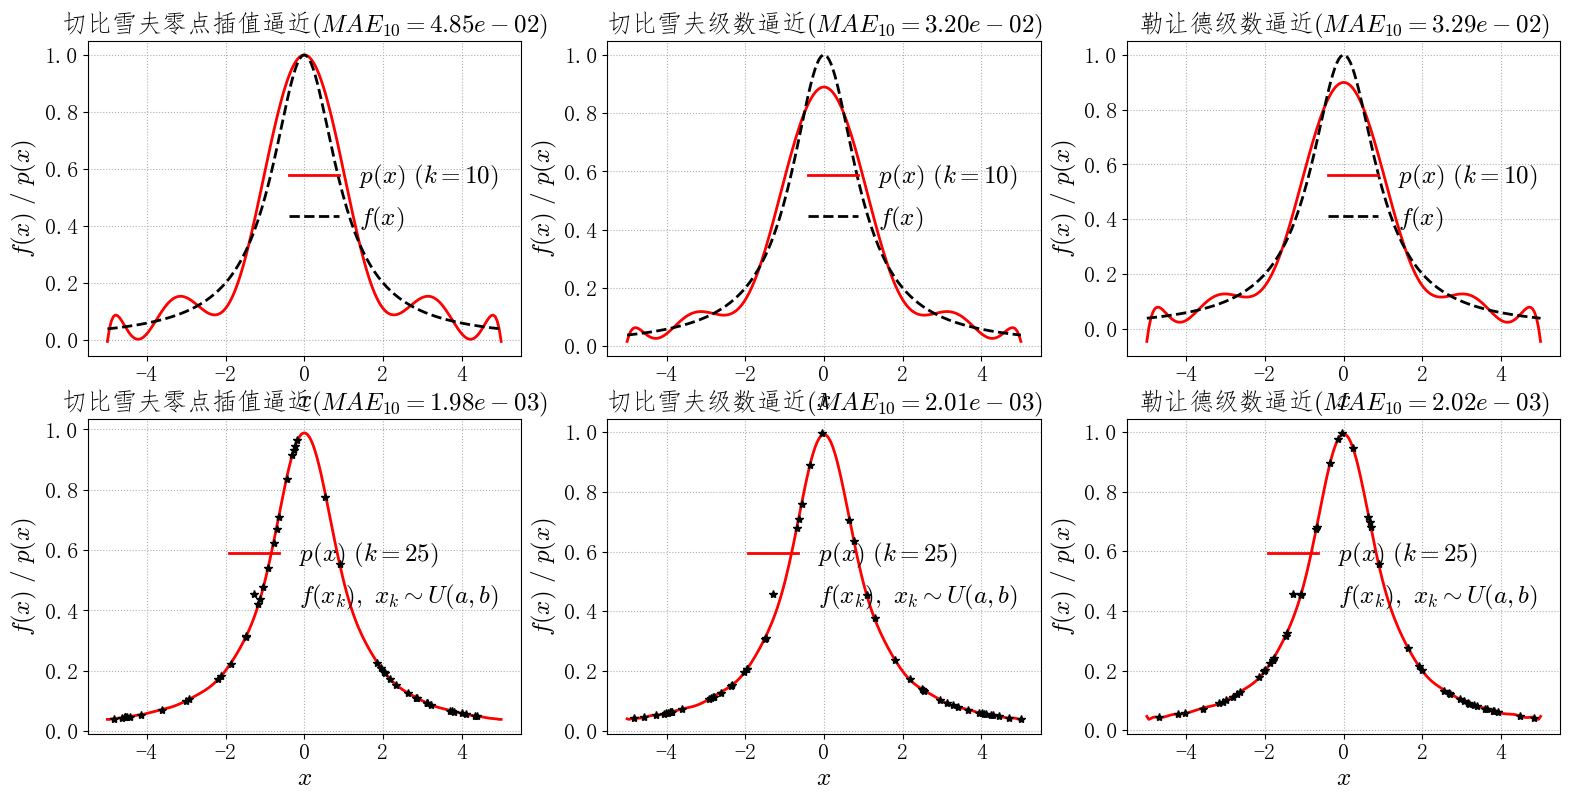

In [5]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name:test_chebyshev_legendre.py
@copyright: http://maths.xynu.edu.cn
"""

import sympy
from function_approximation_03.chebyshev_zero_points_interp import ChebyshevZeroPointsInterpolation
from function_approximation_03.chebyshev_series_approximation import ChebyshevSeriesApproximation
from function_approximation_03.legendre_series_approximation import LegendreSeriesApproximation
import matplotlib.pyplot as plt
import numpy as np

t = sympy.Symbol("t")
runge_fun, sym_fun = lambda x: 1 / (x ** 2 + 1), 1 / (t ** 2 + 1)  # 龙格函数
fun = lambda x: np.sin(2 * x + np.pi / 6) * np.exp(-0.4 * x)
plt.figure(figsize=(19, 9))
for i, order in enumerate([10, 25]):
    plt.subplot(231 + 3 * i)  # 321, 322
    czpi = ChebyshevZeroPointsInterpolation(runge_fun, x_span=[-5, 5], orders=order)
    czpi.fit_approximation()
    if i == 0:
        czpi.plt_approximation(is_show=False)
    else:
        czpi.plt_approximation(is_show=False, is_fh_marker=True)
    print("切比雪夫多项式零点插值逼近最大绝对值误差是：", czpi.max_abs_error)
    print("=" * 70)
    plt.subplot(232 + 3 * i)  # 323, 324
    csa = ChebyshevSeriesApproximation(sym_fun, x_span=[-5, 5], k=order)
    csa.fit_approximation()
    if i == 0:
        csa.plt_approximate(is_show=False)
    else:
        csa.plt_approximate(is_show=False, is_fh_marker=True)
    print("切比雪夫级数逼近最大绝对值误差是：", csa.max_abs_error)
    print("=" * 70)
    plt.subplot(233 + 3 * i)  # 325, 326
    lsa = LegendreSeriesApproximation(sym_fun, x_span=[-5, 5], k=order)
    lsa.fit_approximation()
    if i == 0:
        lsa.plt_approximate(is_show=False)
    else:
        lsa.plt_approximate(is_show=False, is_fh_marker=True)
    print("勒让德级数逼近最大绝对值误差是：", lsa.max_abs_error)
plt.show()



## 最佳逼近多项式

### 最佳一致逼近多项式

In [1]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name: best_approximation_entity_utils.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import sympy
from util_font import *


class BestApproximationUtils:
    """
    最佳多项式逼近工具类
    """
    approximation_poly = None  # 逼近的多项式
    poly_coefficient = None  # 逼近多项式的系数
    polynomial_orders = None  # 逼近多项式各项阶次
    max_abs_error = np.inf  # 10次模拟选最大的
    mae = np.inf  # 10次模拟均值

    def __init__(self, fun, k, interval=np.array([-1, 1])):
        self.fun, self.approximate_fx = self.lambda_function(fun)  # 所逼近的函数
        self.k = k  # 逼近已知函数所需项数
        self.a, self.b = interval[0], interval[1]  # 区间左右端点

    @staticmethod
    def lambda_function(fun):
        """
        转换为lambda函数
        :param fun: 符号函数
        :return:
        """
        t = fun.free_symbols.pop()
        return fun, sympy.lambdify(t, fun)

    def error_analysis(self):  # 参考类OrthogonalPolynomialUtils设计
        """
        误差分析：10次模拟，每次100个随机点，分析绝对误差均值和最大绝对误差
        :return:
        """
        mae = np.zeros(10)  # 存储10次随机值，真值与逼近多项式的均方根误差
        max_error = np.zeros(10)  # 存储10次随机模拟，每次最大的绝对值误差
        for i in range(10):
            xi = self.a + np.random.rand(100) * (self.b - self.a)
            xi = np.array(sorted(xi))  # list-->ndarray，升序排列
            y_true = self.approximate_fx(xi)  # 原函数精确值
            yi = self.predict_x0(xi)  # 逼近多项式值
            mae[i] = np.mean(np.abs(yi - y_true))  # 100个随机点的绝对误差均值
            max_error[i] = max(np.abs(yi - y_true))  # 100个随机点选最大的绝对值误差
        self.max_abs_error = max(max_error)  # 10次模拟选最大的
        self.mae = float(np.mean(mae))  # 10次模拟均值

    def predict_x0(self, x0):
        """
        求解逼近多项式给定点的值
        :return:
        """
        t = self.approximation_poly.free_symbols.pop()
        appr_poly = sympy.lambdify(t, self.approximation_poly)
        return appr_poly(x0)

    def plt_approximation(self, sub_title, is_show=True, is_fh_marker=False):
        """
        可视化逼近多项式。针对被逼近函数，如果is_fh_marker为True，则随机化50个点，并标记
        :param sub_title: 子标题
        :param is_show: 用于绘制子图，如果绘制子图，则值为False
        :param is_fh_marker: 真实函数是曲线类型还是marker类型
        """
        if is_show:
            plt.figure(figsize=(7, 5))
        xi = np.linspace(self.a, self.b, 200)
        yi_hat = self.predict_x0(xi)  # 求解模拟点
        plt.plot(xi, yi_hat, "r-", lw=2, label="$p(x) \ (k=%d)$" % self.k)
        if is_fh_marker:
            xi = self.a + np.random.rand(100) * (self.b - self.a)
            xi = np.array(sorted(xi))  # list-->ndarray，升序排列
            y_true = self.approximate_fx(xi)
            plt.plot(xi, y_true, "k*", label="$f(x_k), \ x_k \sim U(a, b)$")
        else:
            y_true = self.approximate_fx(xi)
            plt.plot(xi, y_true, "k--", lw=2, label="$f(x)$")
        plt.xlabel(r"$x$", fontdict={"fontsize": 18})
        plt.ylabel(r"$f(x) \quad / \quad p(x)$", fontdict={"fontsize": 18})
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        # mse_10的含义为10次随机绝对误差均值
        plt.title("%s逼近$(MAE_{10}=%.2e)$" % (sub_title, self.mae), fontdict={"fontsize": 18})
        plt.legend(frameon=False, fontsize=18)
        plt.grid(ls=":")
        if is_show:
            plt.show()



In [2]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name:best_uniform_approximation.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import sympy
import numpy as np
import math
from function_approximation_03.utils.best_approximation_utils import BestApproximationUtils


class BestUniformApproximation(BestApproximationUtils):
    """
    最佳一致多项式逼近，列梅兹算法。继承BestApproximationUtils的属性和实例方法
    由于需要生成逼近多项式，故仍采用符号运算 + 数值运算
    """
    cross_point_group = None  # f(x)-p(x)的交错点组

    def __init__(self, fun, k, interval=np.array([-1, 1]), eps=1e-8, h=1e-3):
        BestApproximationUtils.__init__(self, fun, k, interval)  # 继承父类属性
        self.eps = eps  # 逼近精度
        self.h = h  # 步长，用于查找|p(x)-f(x)|误差最大的x点

    def solve_coefficient(self, x, fx):
        """
        求解逼近多项式的系数向量
        :param x: 点集
        :param fx: 点集的原函数精确值
        :return: 系数
        """
        A = np.zeros((self.k + 2, self.k + 2))  # n + 2个交错点
        for i in range(self.k + 2):
            A[i, :-1] = x[i] ** np.arange(0, self.k + 1)
            A[i, -1] = (-1) ** i
        return np.linalg.solve(A, np.asarray(fx, dtype=np.float64))  # p(x)的初始系数

    def fit_approximation(self):
        """
        逼近核心算法
        :return:
        """
        t = self.fun.free_symbols.pop()
        px = sympy.Matrix.zeros(self.k + 1, 1)
        for i in range(self.k + 1):
            px[i] = np.power(t, i)  # p(x)多项式，幂次多项式
        # 1. 初始化x（n + 1次切比雪夫多项式的交错点组）和f(x)，区间[-1, 1]
        x = np.zeros(self.k + 2)  # 初始化的交错点组
        fx = sympy.Matrix.zeros(self.k + 2, 1)  # 符号矩阵
        for i in range(self.k + 2):
            x[i] = 0.5 * (self.a + self.b + (self.b - self.a) *
                          math.cos(np.pi * (self.k + 1 - i) / (self.k + 1)))
            fx[i] = self.fun.evalf(subs={t: x[i]})

        # 2. 构造矩阵，并求解线性方程组，得到初始的逼近多项式
        self.poly_coefficient = self.solve_coefficient(x, fx)  # p(x)的初始系数
        # 3. 确定新的点集
        u = self.poly_coefficient[-1]  # 算法中的u
        max_t, max_x, tol = 0.0, np.infty, np.infty  # 记录abs(fx - px)取最大值的x，精度初始化为正无穷
        while tol > self.eps:
            xi = self.a  # xi初始化为区间左端点
            # 3.1 此循环找出abs(f(x)-p(x))取最大值的x
            while xi < self.b:
                xi += self.h * (self.b - self.a) / self.k  # 等距划分且递增步长
                px1 = np.asarray(px.evalf(subs={t: xi}), dtype=np.float64)  # 各幂次在xi得值
                pt = np.dot(px1.reshape(-1), self.poly_coefficient[:-1].reshape(-1))  # 逼近多项式的近似值
                ft = self.fun.evalf(subs={t: xi})  # 原函数在xi的精确值
                if np.abs(ft - pt) > max_t:
                    max_x, max_t = xi, np.abs(ft - pt)
            if max_x > self.b:  # 未找到，则确定右端点为最大的x
                max_x = self.b

            # 3.2 确定新点集的三种情况
            if self.a <= max_x <= x[1]:  # 第一种情况
                d1, d2 = self.cal_point_set(t, px, x[1], max_x)
                if d1 * d2 > 0:  # 同号，d1表示f(x1)-p(x1)，d2表示f(max_x)-p(max_x)
                    print("第一种情况：替代x(1)，x(1)_old=%.5f, x(1)_new=%.5f" % (x[0], max_x))
                    x[0] = max_x
            elif x[-2] <= max_x <= self.b:  # 第二种情况
                d1, d2 = self.cal_point_set(t, px, x[-2], max_x)
                if d1 * d2 > 0:
                    print("第二种情况：替代x(n+1)，x(n+1)_old=%.5f, x(n+1)_new=%.5f"
                          % (x[-2], max_x))
                    x[-2] = max_x  # x[-1]为u
            else:  # 第三种情况
                idx_x = None  # 找到max_x所在区间的索引
                for i in range(1, self.k + 1):
                    if x[i] <= max_x <= x[i + 1] or x[i + 1] <= max_x <= x[i]:
                        idx_x = i
                        break
                if idx_x is not None:
                    d1, d2 = self.cal_point_set(t, px, x[idx_x], max_x)
                    if d1 * d2 > 0:
                        print("第三种情况：替代x(i+1)，x(i+1)_old=%.5f, x(i+1)_new=%.5f"
                              % (x[idx_x], max_x))
                        x[idx_x] = max_x
            # 3.3 重新计算f(x)的精确值和逼近多项式系数
            for i in range(self.k + 2):
                fx[i] = self.fun.evalf(subs={t: x[i]})
            self.poly_coefficient = self.solve_coefficient(x, fx)  # 求解系数，更新逼近多项式
            tol = np.abs(self.poly_coefficient[-1] - u)  # 精度更新
            u = self.poly_coefficient[-1]  # u更新

        # 4. 满足精度要求后，逼近多项式各项特征组合
        self.poly_coefficient = self.poly_coefficient[:-1].reshape(-1)  # 多项式系数
        self.approximation_poly = self.poly_coefficient[0] * px[0]
        for i in range(1, self.k + 1):
            self.approximation_poly += self.poly_coefficient[i] * px[i]  # 最佳一致逼近多项式
        self.abs_error = dict({"u": u[0], "tol": tol[0]})  # 逼近误差
        polynomial = sympy.Poly(self.approximation_poly, t)  # 构造多项式对象
        self.polynomial_orders = polynomial.monoms()[::-1]  # 阶次，从低到高，故反转
        BestApproximationUtils.error_analysis(self)  # 调用父类，误差分析
        self.cal_cross_point_group(t, x)  # 计算交错点组

    def cal_cross_point_group(self, t, x):
        """
        计算f(x) - p(x)的交错点组
        :return:
        """
        fun_expr = sympy.lambdify(t, self.fun)  # 构成lambda函数
        poly_expr = sympy.lambdify(t, self.approximation_poly)
        self.cross_point_group = fun_expr(x) - poly_expr(x)

    def cal_point_set(self, t, px, x, max_x):
        """
        计算新的点集
        :param t: 符号变量
        :param px: 符号多项式
        :param x: n + 1个点集
        :param max_x: 取最大值的x
        :return:
        """
        f0, fm = self.fun.evalf(subs={t: x}), self.fun.evalf(subs={t: max_x})
        px1 = np.asarray(px.evalf(subs={t: x}), dtype=np.float64)
        pt = np.dot(px1.reshape(-1), self.poly_coefficient[:-1].reshape(-1))
        pm1 = np.asarray(px.evalf(subs={t: max_x}), dtype=np.float64)
        pm = np.dot(pm1.reshape(-1), self.poly_coefficient[:-1].reshape(-1))
        d1, d2 = f0 - pt, fm - pm
        return d1, d2

    def predict_x0(self, x0):
        """
        求解逼近多项式给定点的值
        :return:
        """
        return BestApproximationUtils.predict_x0(self, x0)

    def plt_approximate(self, is_show=True, is_fh_marker=False):
        """
        可视化函数和逼近多项式函数
        :return:
        """
        BestApproximationUtils.plt_approximation(self, "最佳一致(列梅兹)", is_show, is_fh_marker)


第三种情况：替代x(i+1)，x(i+1)_old=0.69907, x(i+1)_new=1.26606
第三种情况：替代x(i+1)，x(i+1)_old=-1.95875, x(i+1)_new=-1.29852
order=6 ，最佳一致逼近多项式的逼近误差精度为： {'u': np.float64(4.979155099319223), 'tol': np.float64(0.0)}
order=6 ，最佳一致逼近多项式的最大绝对误差为： 15.882965134353
交错点组： [ 4.9791551 -4.9791551  4.9791551 -4.9791551  4.9791551 -4.9791551
  4.9791551 -4.9791551]
order=10 ，最佳一致逼近多项式的逼近误差精度为： {'u': np.float64(6.435273145317462e-05), 'tol': np.float64(0.0)}
order=10 ，最佳一致逼近多项式的最大绝对误差为： 18.381645527015
交错点组： [ 6.43527286e-05 -6.43527340e-05  6.43527294e-05 -6.43527321e-05
  6.43527310e-05 -6.43527303e-05  6.43527328e-05 -6.43527316e-05
  6.43527302e-05 -6.43527338e-05  6.43527293e-05 -6.43527336e-05]
order=25 ，最佳一致逼近多项式的逼近误差精度为： {'u': np.float64(-0.0005959020306765617), 'tol': np.float64(0.0)}
order=25 ，最佳一致逼近多项式的最大绝对误差为： 0.0006067518205421507
交错点组： [-0.00059591  0.00059589 -0.00059591  0.0005959  -0.00059591  0.0005959
 -0.0005959   0.0005959  -0.0005959   0.0005959  -0.0005959   0.0005959
 -0.0005959   0.0005959

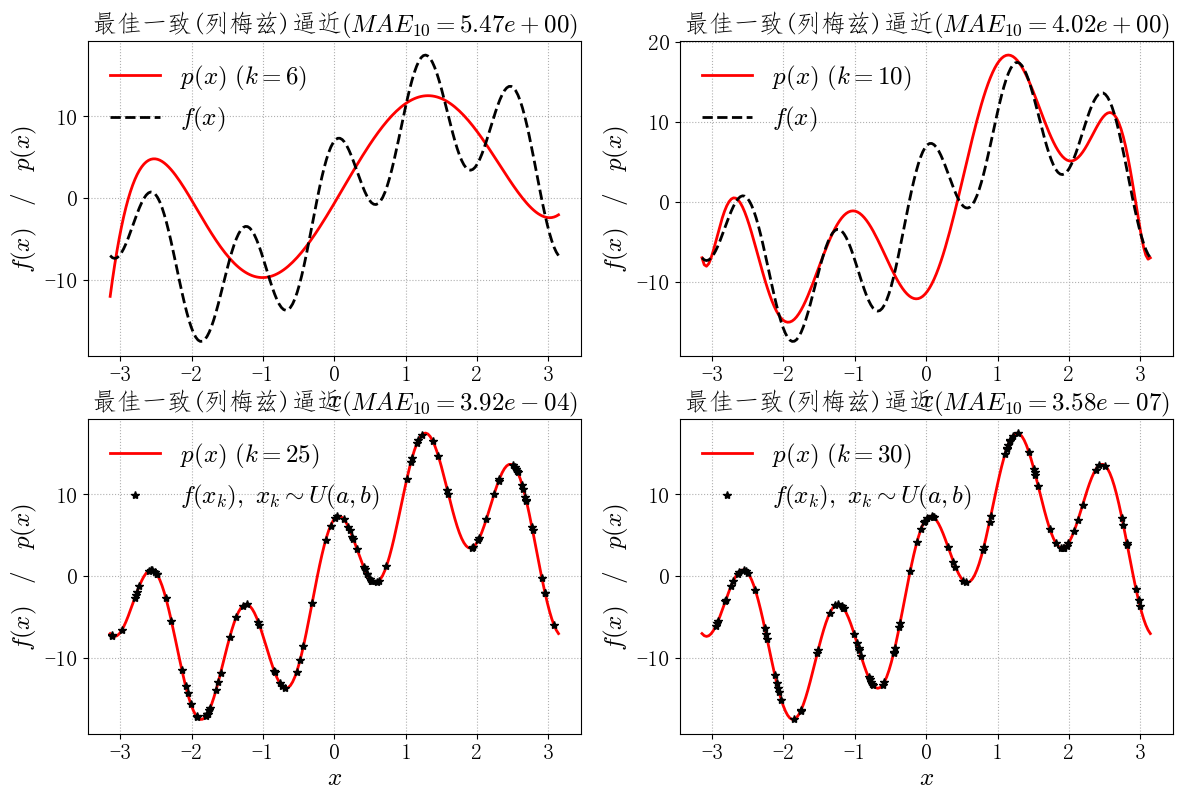

In [3]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:test_best_unappr.py
@IDE:PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import sympy
import numpy as np
from util_font import *
from function_approximation_03.best_uniform_approximation import BestUniformApproximation

t = sympy.Symbol("t")
fun = 11 * sympy.sin(t) + 7 * sympy.cos(5 * t)
# fun = sympy.tan(sympy.cos((np.sqrt(3) + sympy.sin(2 * t)) / (3 + 4 * t ** 2)))  # 被逼近函数
plt.figure(figsize=(14, 9))
orders = [6, 10, 25, 30]
for i, order in enumerate(orders):
    plt.subplot(221 + i)
    bua = BestUniformApproximation(fun, k=order, interval=[-np.pi, np.pi], eps=1e-10)
    bua.fit_approximation()
    if order in [25, 30]:
        bua.plt_approximate(is_show=False, is_fh_marker=True)
    else:
        bua.plt_approximate(is_show=False)
    print("order=%d" % order, "，最佳一致逼近多项式的逼近误差精度为：", bua.abs_error)
    print("order=%d" % order, "，最佳一致逼近多项式的最大绝对误差为：", bua.max_abs_error)
    print("交错点组：", bua.cross_point_group)
plt.show()

## 最佳平方多项式逼近

In [1]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:best_square_approximation.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import sympy
import numpy as np
import math
from scipy import integrate
from function_approximation_03.utils.best_approximation_utils import BestApproximationUtils
from iterative_solution_linear_equation_07.pre_conjugate_gradient \
    import PreConjugateGradient  # 预处理共轭梯度法


class BestSquarePolynomiaApproximation(BestApproximationUtils):
    """
    最佳平方多项式逼近，继承BestApproximationUtils的属性和方法
    """

    def fit_approximation(self):
        """
        最佳平方逼近核心算法
        :return:
        """
        t = self.fun.free_symbols.pop()  # 获取方程的自由变量符号
        H = np.zeros((self.k + 1, self.k + 1), dtype=np.float64)
        d = np.zeros(self.k + 1)
        func = self.fun / t  # 初始化，方便循环内统一
        for i in range(self.k + 1):
            # H矩阵的第一行
            H[0, i] = (math.pow(self.b, i + 1) - math.pow(self.a, i + 1)) / (i + 1)
            func = func * t  # 被积函数，随着i增加，累乘，幂次增加
            expr = sympy.lambdify(t, func)
            d[i] = integrate.quad(expr, self.a, self.b, full_output=1)[0]  # 数值积分
        for i in range(1, self.k + 1):
            # H上一行从第二个元素开始赋值给下一行，从第一个元素到倒数第二个元素
            H[i, :-1] = H[i - 1, 1:]
            # 计算H当前行的最后一个元素
            f1, f2 = math.pow(self.b, self.k + 1 + i), math.pow(self.a, self.k + 1 + i)
            H[i, -1] = (f1 - f2) / (self.k + i + 1)  # 形成H矩阵当前行的最后一个值
        self.poly_coefficient = np.linalg.solve(H, d)  # 求解逼近多项式的系数
        # pre_cg = PreconditionedConjugateGradient(H, d, np.zeros(len(d)), eps=1e-16)
        # self.poly_coefficient = pre_cg.fit_solve()

        # 逼近多项式各项特征组合
        px = sympy.Matrix.zeros(self.k + 1, 1)
        for i in range(self.k + 1):
            px[i] = np.power(t, i)  # p(x)多项式
        self.approximation_poly = self.poly_coefficient[0] * px[0]  # 符号运算
        for i in range(1, self.k + 1):
            self.approximation_poly += self.poly_coefficient[i] * px[i]
        polynomial = sympy.Poly(self.approximation_poly, t)
        self.polynomial_orders = polynomial.monoms()[::-1]  # 阶次，从低到高
        BestApproximationUtils.error_analysis(self)  # 调用父类方法

    def predict_x0(self, x0):
        """
        求解逼近多项式给定点的值
        :return:
        """
        return BestApproximationUtils.predict_x0(self, x0)

    def plt_approximate(self, is_show=True, is_fh_marker=False):
        """
        可视化函数和逼近多项式函数
        :return:
        """
        BestApproximationUtils.plt_approximation(self, "最佳平方", is_show, is_fh_marker)


order=1 ，最佳平方逼近多项式的绝对误差均值为： 0.02242108588764482
order=1 ，最佳平方逼近多项式的最大绝对误差为： 0.06545750291492558
[0.93432005 0.42694705]
order=3 ，最佳平方逼近多项式的绝对误差均值为： 5.1956865143298894e-05
order=3 ，最佳平方逼近多项式的最大绝对误差为： 0.00029448636389406424
[ 1.00030538 -0.00818738  0.55280181 -0.13074153]
order=7 ，最佳平方逼近多项式的绝对误差均值为： 2.289546155599398e-07
order=7 ，最佳平方逼近多项式的最大绝对误差为： 1.1355415493463639e-06
[ 9.99998861e-01  8.23851192e-05  4.98558025e-01  1.04610790e-02
 -1.62813799e-01  7.07668272e-02  4.23517548e-03 -7.07595042e-03]


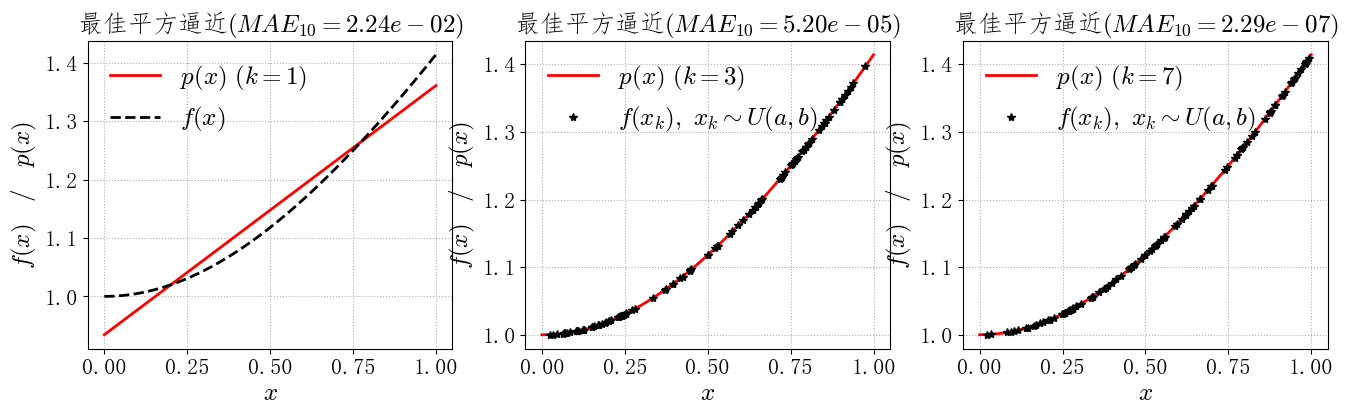

In [2]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:test_best_square_appr.py
@IDE:PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import sympy
import numpy as np
from util_font import *
from function_approximation_03.best_square_approximation import BestSquarePolynomiaApproximation
from function_approximation_03.best_uniform_approximation import BestUniformApproximation


t = sympy.Symbol("t")
# fun = sympy.sin(t) * sympy.exp(-t)
# fun = 11 * sympy.sin(t) + 7 * sympy.cos(5 * t)
fun = sympy.sqrt(1 + t ** 2)
plt.figure(figsize=(16, 4))
orders = [1, 3, 7]
# orders = [6, 10, 25, 30]
for i, order in enumerate(orders):
    plt.subplot(131 + i)
    # bspa = BestSquarePolynomiaApproximation(fun, k=order, interval=[-np.pi, np.pi])
    bspa = BestSquarePolynomiaApproximation(fun, k=order, interval=[0, 1])
    bspa.fit_approximation()
    if order == 1:
        bspa.plt_approximate(is_show=False)
    else:
        bspa.plt_approximate(is_show=False, is_fh_marker=True)
    print("order=%d" % order, "，最佳平方逼近多项式的绝对误差均值为：", bspa.mae)
    print("order=%d" % order, "，最佳平方逼近多项式的最大绝对误差为：", bspa.max_abs_error)
    print(bspa.poly_coefficient)
plt.show()


## 三角多项式逼近

In [3]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name: trigonometric_polynomial_appr.py
@IDE:PyCharm   Python:3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import sympy
import numpy as np
from util_font import *


class TrigonometricPolynomialApproximation:
    """
    当被逼近函数为周期函数时，用代数多项式逼近效率不高，而且误差较大，这时用三角多项式来逼近是较好的选择。
    三角多项式逼近即傅里叶逼近，任一周期函数都可以展开为傅里叶级数，通过选取有限的展开级数，就可以达到所
    需精度的逼近效果。
    """

    def __init__(self, y, interval, fun=None):
        # 被逼近函数fun，被逼近的离散数值y，逼近区间self.a, self.b = interval[0], interval[1]
        self.fun = fun  # 被逼近函数，可以为None，如果提供，可度量逼近性能
        self.y = np.asarray(y, dtype=np.float64)  # 被逼近的离散数值
        self.a, self.b = interval[0], interval[1]  # 逼近区间
        self.Ak, self.Bk = None, None  # 展开后的余弦项、正弦项系数
        self.approximation_poly = None  # 逼近的三角多项式

    def fit_approximation(self):
        """
        核心算法：三角多项式插值逼近
        :return:
        """
        t = sympy.Symbol("t")
        n = len(self.y)  # 离散数据点个数
        m = n // 2  # ak系数的个数
        self.Ak = np.zeros(m + 1)
        self.approximation_poly = 0.0
        idx = np.linspace(0, n, n, endpoint=False, dtype=np.int64)
        if np.mod(n, 2) == 0:  # 偶数个数
            self.Bk = np.zeros(m - 1)
            for k in range(m + 1):
                self.Ak[k] = np.dot(self.y, np.cos(np.pi * idx * k / m))
                if k == 0 or k == m:  # 第一个值a0和最后一个值am特殊处理
                    self.Ak[k] = self.Ak[k] / (2 * m) * (-1) ** k
                else:
                    self.Ak[k] = self.Ak[k] / m * (-1) ** k
                self.approximation_poly += self.Ak[k] * sympy.cos(k * t)
            for k in range(1, m):
                self.Bk[k - 1] = np.dot(self.y, np.sin(np.pi * idx * k / m)) / \
                                 m * (-1) ** k
                self.approximation_poly += self.Bk[k - 1] * sympy.sin(k * t)
        else:  # 奇数个数
            self.Bk = np.zeros(m)
            for k in range(m + 1):
                self.Ak[k] = np.dot(self.y, np.cos(np.pi * idx * k * 2 / (2 * m + 1)))
                if k == 0:
                    self.Ak[k] = self.Ak[k] * 1 / (2 * m + 1) * (-1) ** k
                else:
                    self.Ak[k] = self.Ak[k] * 2 / (2 * m + 1) * (-1) ** k
                self.approximation_poly += self.Ak[k] * sympy.cos(k * t)
            for k in range(1, m + 1):
                sv = np.sin(np.pi * idx * k * 2 / (2 * m + 1))  # Bk子项
                self.Bk[k - 1] = np.dot(self.y, sv) * 2 / (2 * m + 1) * (-1) ** k
                self.approximation_poly += self.Bk[k - 1] * sympy.sin(k * t)

    def predict_x0(self, x0):
        """
        求解三角插值逼近在给定点的值
        :return:
        """
        t = self.approximation_poly.free_symbols.pop()
        approximation_poly = sympy.lambdify(t, self.approximation_poly)  # 转换成lambda函数
        # 区间变换，[a, b] -->[-pi, pi]
        x0 = np.asarray(x0, dtype=np.float64)
        xi = (x0 - (self.a + self.b) / 2) * 2 / (self.b - self.a) * np.pi
        y0 = approximation_poly(xi)
        return y0

    def plt_approximate(self, x0=None, y0=None, is_show=True, is_fh_marker=False):
        """
        可视化函数和三角插值逼近函数
        :return:
        """
        if is_show:
            plt.figure(figsize=(7, 5))

        if self.fun is not None:
            xi = np.linspace(self.a, self.b, 200)
            y_true = self.fun(xi)
            yi_hat = self.predict_x0(xi)  # 求解模拟点
            plt.plot(xi, yi_hat, "r-", lw=2, label="$p(x)$三角逼近")
            if is_fh_marker:
                xi = self.a + np.random.rand(50) * (self.b - self.a)
                xi = np.array(sorted(xi))  # list-->ndarray，升序排列
                y_true_ = self.fun(xi)
                plt.plot(xi, y_true_, "k*", label="$f(x_k), \ x_k \sim U(a, b)$")
            else:
                plt.plot(xi, y_true, "k--", lw=2, label="$f(x)$")
            mae = np.mean(np.abs(yi_hat - y_true))
            print("平均绝对值误差：%.10e" % mae)
            print("最大绝对值误差：%.10e" % np.max(np.abs(y_true - yi_hat)))
            plt.title("三角多项式逼近$(MAE=%.2e, n_{nodes}=%d)$" % (mae, len(self.y)), fontdict={"fontsize": 18})
            plt.ylabel(r"$f(x) \quad / \quad p(x)$", fontdict={"fontsize": 18})
            plt.legend(frameon=False, fontsize=18)
        elif x0 is not None and y0 is not None:
            xi = np.linspace(self.a, self.b, 200)
            yi = self.predict_x0(xi)  # 求傅里叶逼近的值
            plt.title("最小二乘三角多项式逼近函数曲线 ", fontdict={"fontsize": 18})
            plt.ylabel(r"$p(x)$", fontdict={"fontsize": 18})
            plt.plot(xi, yi, "k-", lw=1.5, label="$p(x)$三角逼近")
            plt.plot(x0, y0, "ro", label="$(x_k, y_k)$")
            plt.legend(frameon=False, fontsize=17, loc="upper left")
        plt.xlabel(r"$x$", fontdict={"fontsize": 18})
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        plt.grid(ls=":")
        if is_show:
            plt.show()


正弦项系数：
 [-0.10221901  0.27540621 -2.05295495]
余弦项系数：
 [-0.1264264   0.2602724  -0.30111397  1.1213715   0.04589647]
傅里叶逼近多项式：
 -0.102219005228077*sin(t) + 0.275406212671449*sin(2*t) - 2.05295494939534*sin(3*t) + 0.260272396590884*cos(t) - 0.301113969358163*cos(2*t) + 1.12137150137574*cos(3*t) + 0.0458964736174918*cos(4*t) - 0.126426402225957
平均绝对值误差：2.8625624218e-01
最大绝对值误差：9.1225301958e-01
正弦项系数：
 [-0.06940664  0.20211345 -1.91364701 -0.32524882  0.13930794 -0.07329277
  0.03281236]
余弦项系数：
 [-0.0917109   0.19315568 -0.24244768  1.08494594  0.04589647  0.03642556
 -0.05866629  0.06711672 -0.0347155 ]
傅里叶逼近多项式：
 -0.069406640756795*sin(t) + 0.202113446610163*sin(2*t) - 1.91364701261337*sin(3*t) - 0.325248816280318*sin(4*t) + 0.139307936781974*sin(5*t) - 0.0732927660612867*sin(6*t) + 0.0328123644712845*sin(7*t) + 0.193155675122529*cos(t) - 0.242447679331405*cos(2*t) + 1.08494593652718*cos(3*t) + 0.045896473617492*cos(4*t) + 0.0364255648485635*cos(5*t) - 0.0586662900267553*cos(6*t) + 0.067

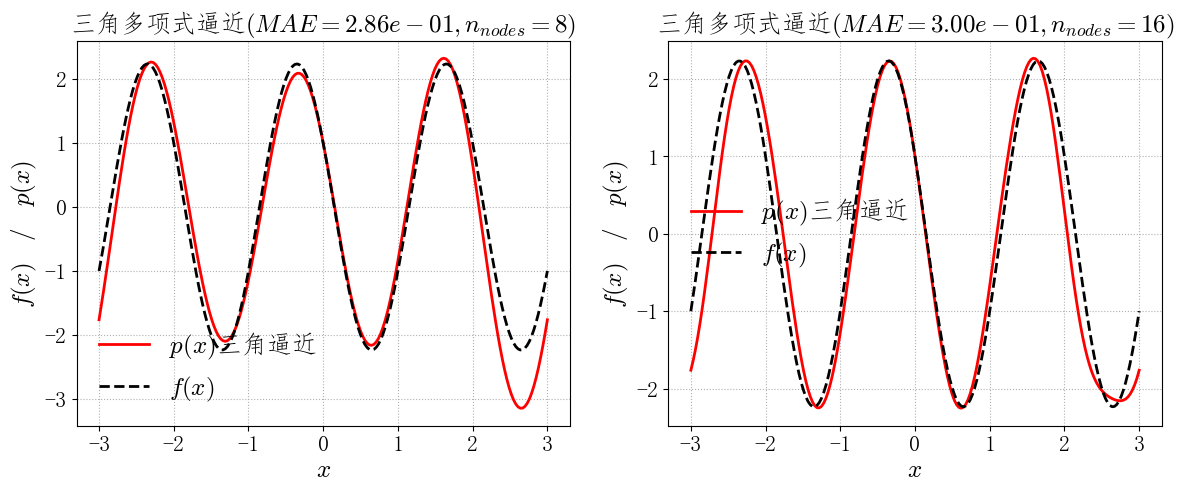

In [4]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:test_trigonometric_poly_appr.py
@IDE:PyCharm   Python:3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import matplotlib.pyplot as plt
from function_approximation_03.trigonometric_polynomial_appr import TrigonometricPolynomialApproximation

fun = lambda x: x ** 4 - 3 * x ** 3 + 2 * x ** 2 - np.tan(x * (x - 2))

fun2 = lambda x: np.sin(x) * np.exp(-x)

# 例8测试代码
# p_num = [8, 24]  # 离散点数
# plt.figure(figsize=(14, 5))
# for i, p in enumerate(p_num):
#     x = np.linspace(0, 2, p, endpoint=False)
#     tpa = TrigonometricPolynomialApproximation(y=fun(x), interval=[0, 2], fun=fun)
#     tpa.fit_approximation()
#     print("正弦项系数：\n", tpa.Bk)
#     print("余弦项系数：\n", tpa.Ak)
#     print("傅里叶逼近多项式：\n", tpa.approximation_poly)
#     plt.subplot(121 + i)
#     tpa.plt_approximate(is_show=False, is_fh_marker=True)  # 可视化
# plt.show()
#
# plt.figure(figsize=(14, 5))
# x = np.linspace(0, 2 * np.pi, 25, endpoint=True)
# tpa = TrigonometricPolynomialApproximation(y=fun2(x), interval=[0, 2 * np.pi], fun=fun2)
# tpa.fit_approximation()
# plt.subplot(121)
# tpa.plt_approximate(is_show=False)  # 可视化
# x = np.linspace(0, 2 * np.pi, 50, endpoint=True)
# tpa = TrigonometricPolynomialApproximation(y=fun2(x), interval=[0, 2 * np.pi], fun=fun2)
# tpa.fit_approximation()
# plt.subplot(122)
# tpa.plt_approximate(is_show=False)  # 可视化
# plt.show()
#
# time = np.linspace(1, 24, 24)
# temperature = np.array([58, 58, 58, 58, 57, 57, 57, 58, 60, 64, 67, 68,
#                         66, 66, 65, 64, 63, 63, 62, 61, 60, 60, 59, 58])
# tpa = TrigonometricPolynomialApproximation(temperature, interval=[1, 24])
# tpa.fit_approximation()
# print("正弦项系数：\n", tpa.Bk)
# print("余弦项系数：\n", tpa.Ak)
# print("傅里叶逼近多项式：\n", tpa.approximation_poly)
# tpa.plt_approximate(is_show=True, x0=time, y0=temperature)  # 可视化

fh = lambda x: np.cos(np.pi * x) - 2 * np.sin(np.pi * x)
# fh = lambda x: x ** 2 * np.cos(4 * x)
plt.figure(figsize=(14, 5))
x = np.linspace(-np.pi, np.pi, 8, endpoint=False)
tpa = TrigonometricPolynomialApproximation(y=fh(x), interval=[-3, 3], fun=fh)
tpa.fit_approximation()
print("正弦项系数：\n", tpa.Bk)
print("余弦项系数：\n", tpa.Ak)
print("傅里叶逼近多项式：\n", tpa.approximation_poly)
plt.subplot(121)
tpa.plt_approximate(is_show=False)  # 可视化
x = np.linspace(-np.pi, np.pi, 16, endpoint=False)
tpa = TrigonometricPolynomialApproximation(y=fh(x), interval=[-3, 3], fun=fh)
tpa.fit_approximation()
print("正弦项系数：\n", tpa.Bk)
print("余弦项系数：\n", tpa.Ak)
print("傅里叶逼近多项式：\n", tpa.approximation_poly)
plt.subplot(122)
tpa.plt_approximate(is_show=False)  # 可视化
plt.show()


## 快速傅里叶分析

In [5]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name: fast_fourier_transform.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import sympy
from function_approximation_03.trigonometric_polynomial_appr import TrigonometricPolynomialApproximation
from util_font import *


class FastFourierTransformApproximation(TrigonometricPolynomialApproximation):
    """
    快速傅里叶变换逼近算法，继承三角多项式逼近类TrigonometricPolynomialApproximation
    """

    def __init__(self, y, interval, fun=None):
        TrigonometricPolynomialApproximation.__init__(self, y, interval, fun)
        self.n, self.m = len(y), int(len(y) / 2)  # 离散数据的个数n
        if np.ceil(np.log2(self.n)) != np.log2(self.n):
            raise ValueError("离散数据点应满足2 ** p")
        self.p = int(np.log2(self.n))  # N = 2 ** p

    def fit_fourier(self):
        """
        核心算法：快速傅里叶变换逼近
        :return:
        """
        t = sympy.Symbol("t")  # 符号变量
        omega = np.exp(1j * 2 * np.pi / self.n)  # w_N
        W = omega ** np.arange(0, self.m)  # 当N = 2 ** p时，只有N/2个不同的值
        A1, A2 = np.asarray(self.y, dtype=complex), np.zeros(self.n, dtype=complex)  # 初始，表示A_(q-1)和Aq
        for q in range(1, self.p + 1):  # 逐次计算
            i_2, i_3 = 2 ** (self.p - 1), 2 ** (q - 1)  # 索引下标
            if np.mod(q, 2) == 1:  # 奇数
                for k in range(2 ** (self.p - q)):
                    for j in range(2 ** (q - 1)):
                        i_0, i_1 = k * 2 ** q + j, k * 2 ** (q - 1) + j  # 索引下标
                        A2[i_0] = A1[i_1] + A1[i_1 + i_2]
                        A2[i_0 + i_3] = (A1[i_1] - A1[i_1 + i_2]) * W[k * i_3]
            else:  # 偶数
                for k in range(2 ** (self.p - q)):
                    for j in range(2 ** (q - 1)):
                        i_0, i_1 = k * 2 ** q + j, k * 2 ** (q - 1) + j  # 索引下标
                        A1[i_0] = A2[i_1] + A2[i_1 + i_2]
                        A1[i_0 + i_3] = (A2[i_1] - A2[i_1 + i_2]) * W[k * i_3]
        C = np.copy(A1) if np.mod(self.p, 2) == 0 else np.copy(A2)  # 复数系数
        t_e = np.exp(-1j * np.pi * np.arange(0, self.m + 1))
        self.Ak = np.real(C[:self.m + 1] * t_e) / self.m  # 余弦系数
        self.Bk = np.imag(C[:self.m + 1] * t_e) / self.m  # 正弦系数
        self.approximation_poly = self.Ak[0] / 2  # 构造三角逼近多项式，第一项
        for k in range(1, self.m + 1):  # 构造其他项
            self.approximation_poly += self.Ak[k] * sympy.cos(k * t) + \
                                       self.Bk[k] * sympy.sin(k * t)

    def plt_approximate(self, x0=None, y0=None, is_show=True, is_fh_marker=False):
        """
        可视化函数和三角插值逼近函数
        :return:
        """
        if is_show:
            plt.figure(figsize=(7, 5))

        if self.fun is not None:
            xi = np.linspace(self.a, self.b, 200)
            y_true = self.fun(xi)
            yi_hat = self.predict_x0(xi)  # 求解模拟点
            plt.plot(xi, yi_hat, "r-", lw=2, label="$p(x)$三角逼近")
            if is_fh_marker:
                xi = self.a + np.random.rand(50) * (self.b - self.a)
                xi = np.array(sorted(xi))  # list-->ndarray，升序排列
                y_true_ = self.fun(xi)
                plt.plot(xi, y_true_, "k*", label="$f(x_k), \ x_k \sim U(a, b)$")
            else:
                plt.plot(xi, y_true, "k--", lw=2, label="$f(x)$")
            mae = np.mean(np.abs(yi_hat - y_true))
            print("平均绝对值误差：%.10e" % mae)
            print("最大绝对值误差：%.10e" % np.max(np.abs(y_true - yi_hat)))
            plt.title("$FFT$逼近函数$(MAE=%.2e, n_{nodes}=%d)$" % (mae, len(self.y)), fontdict={"fontsize": 18})
            plt.ylabel(r"$f(x) \quad / \quad p(x)$", fontdict={"fontsize": 18})
            plt.legend(frameon=False, fontsize=18)
        elif x0 is not None and y0 is not None:
            xi = np.linspace(self.a, self.b, 200)
            yi = self.predict_x0(xi)  # 求傅里叶逼近的值
            plt.title("快速傅里叶变换$FFT$最小二乘三角逼近函数曲线 ", fontdict={"fontsize": 18})
            plt.ylabel(r"$p(x)$", fontdict={"fontsize": 18})
            plt.plot(xi, yi, "k-", lw=1.5, label="$p(x)$三角逼近")
            plt.plot(x0, y0, "ro", label="$(x_k, y_k)$")
            plt.legend(frameon=False, fontsize=17, loc="upper left")
        plt.xlabel(r"$x$", fontdict={"fontsize": 18})
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        plt.grid(ls=":")
        if is_show:
            plt.show()


平均绝对值误差：7.2430283074e-02
最大绝对值误差：2.5119196376e-01
平均绝对值误差：3.7038831560e-03
最大绝对值误差：4.6917548882e-02


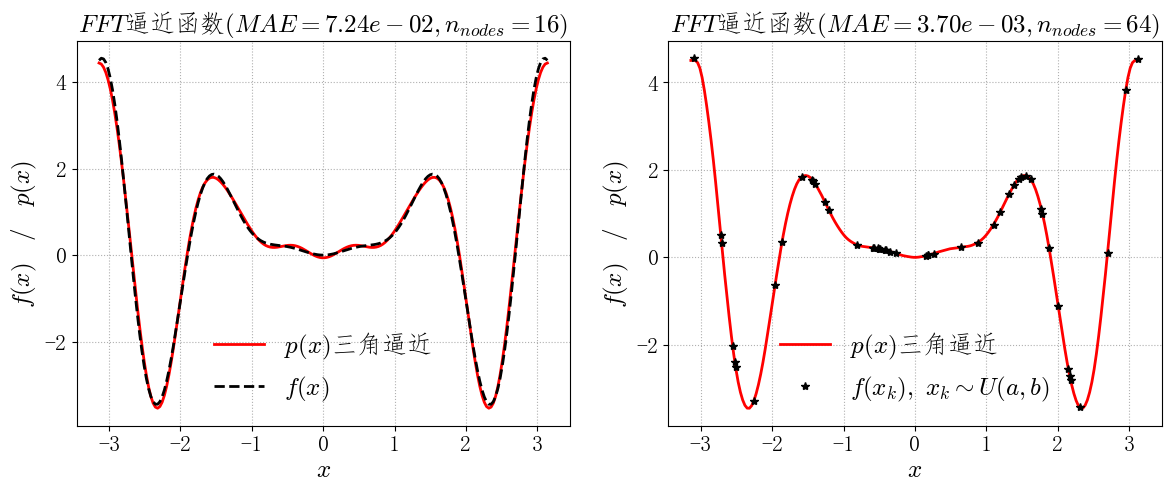

In [6]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name: test_FFT.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import matplotlib.pyplot as plt
from function_approximation_03.fast_fourier_transform import FastFourierTransformApproximation


# 例7示例
# fun = lambda x: x ** 4 - 3 * x ** 3 + 2 * x ** 2 - np.tan(x * (x - 2))
# x = np.linspace(0, 2, 8, endpoint=False)
#
# p_num = [32, 64]  # 离散点数
# plt.figure(figsize=(14, 5))
# for i, p in enumerate(p_num):
#     x = np.linspace(0, 2, p, endpoint=False)
#     fft = FastFourierTransformApproximation(y=fun(x), interval=[0, 2], fun=fun)
#     fft.fit_fourier()
#     print("正弦项系数：\n", fft.Bk)
#     print("余弦项系数：\n", fft.Ak)
#     print("傅里叶逼近多项式：\n", fft.approximation_poly)
#     plt.subplot(121 + i)
#     fft.plt_approximate(is_show=False, is_fh_marker=True)  # 可视化
# plt.show()
#
# # 例9代码
fun2 = lambda x: 0.5 * x ** 2 * np.cos(4 * x) + np.sin(x ** 2)
# fun2 = lambda x: np.cos(np.pi * x) - 2 * np.sin(np.pi * x)
plt.figure(figsize=(14, 5))
x = np.linspace(-np.pi, np.pi, 16, endpoint=False)
fft = FastFourierTransformApproximation(y=fun2(x), interval=[-np.pi, np.pi], fun=fun2)
fft.fit_fourier()
plt.subplot(121)
fft.plt_approximate(is_show=False, is_fh_marker=False)  # 可视化
x = np.linspace(-np.pi, np.pi, 64, endpoint=False)
fft = FastFourierTransformApproximation(y=fun2(x), interval=[-np.pi, np.pi], fun=fun2)
fft.fit_fourier()
plt.subplot(122)
fft.plt_approximate(is_show=False, is_fh_marker=True)  # 可视化
plt.show()